# Variational Autoencoder (VAE) — PyTorch Tutorial
了解VAE,推荐阅读文章：

- 苏剑林的文章,写的非常好 [变分自动编码器（一）：原来是这么一回事](https://kexue.fm/archives/5253)
- 一定要看,特别是对原理的解析,图文并茂 [What is a variational autoencoder?](https://jaan.io/what-is-variational-autoencoder-vae-tutorial/)
  - [中文翻译](https://zhuanlan.zhihu.com/p/144649293)
- [Understanding Variational Autoencoders (VAEs)](https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)
- 论文[Auto-Encoding Variational Bayes](https://arxiv.org/pdf/1312.6114.pdf)

## 编码器的类型
- Vanilla Autoencoder
- Convolutional Autoencoder (CAE)
- Denoising Autoencoder
- Sparse Autoencoder
- Variational Autoencoder (VAE)
- Sequence-to-Sequence Autoencoder



## 变分自动编码器 | Variational Autoencoder (VAE)
本文将使用MNIST数据做实验,搭建一个VAE网络结构,旨在学习变分自动编码器,潜在空间,重参数技巧三个方面的知识点。

### 概念
编码器： 为从“旧特征”表示中产生“新特征”表示（通过选择或提取）的过程,然后将其逆过程称为解码,解码器。
解码器： 将潜在空间的数据,解码还原的过程,称为解码过程。
潜在空间：降维可以被理解为数据压缩,其中编码器压缩数据（从初始空间到编码空间,也称为隐空间,或潜在空间,latent sapce）,而解码器则用于解压缩。

### 从自动编码器到变分自动编码器的思考

- 自动编码器过拟合问题
- 自动编码器无法生成新的内容
- 自动编码器和内容生成（GEN）的联系是什么？

假设自动编码器的编码器和解码器只有一个线性层,如把2D变换到1D,可以联想到,编码过程和解码过程是有损的。

进一步考虑非线性的网络结构,网络足够复杂,更多的层,可以对原数据进行降维,还保持原数据的重构损失,

在这种情况下,训练出来的自动编码器可以过度的拟合,得到一个输入和输出非常相似的结果；编码器-隐空间-解码器所学习到的信息能充分表达原数据分布,规律等）,但同时也引申出另外一个问题,自动编码器可以生成新的内容吗？

答案是不能的, 一旦自动编码器训练完成,编码器-隐空间-解码器也就定型了,从原理上看是无法生成新的内容；进而有变分编码器,在隐空间上引入一些技巧,让它能够学习到原数据的规律和分布,同时能生成新的内容（同分布）。

### 隐空间
能让编码器生成内容的关键点就在隐空间,从自动编码器的原理上可知,它的隐空间是不可描述的,或者说不规则,里面到底是什么数据没办法用数学公式表达出来,解码器从自动编码器获取出来的数据可能也是无意义的； 那研究者通过对隐空间做修改,让隐空间可描述,也让自动编码器能生成新的内容,这就是**变分自动编码器**。

如果隐空间是有规则的,那生成内容就会变成可能,那该怎么整？规则,主要属性：连续性和完整性
连续性：隐空间的两个相邻的点解码后,得到的两个内容应该是有一点关联的,而不是完全不一致
完整性：隐空间的采样点,经过解码后的内容都是“有意义的”


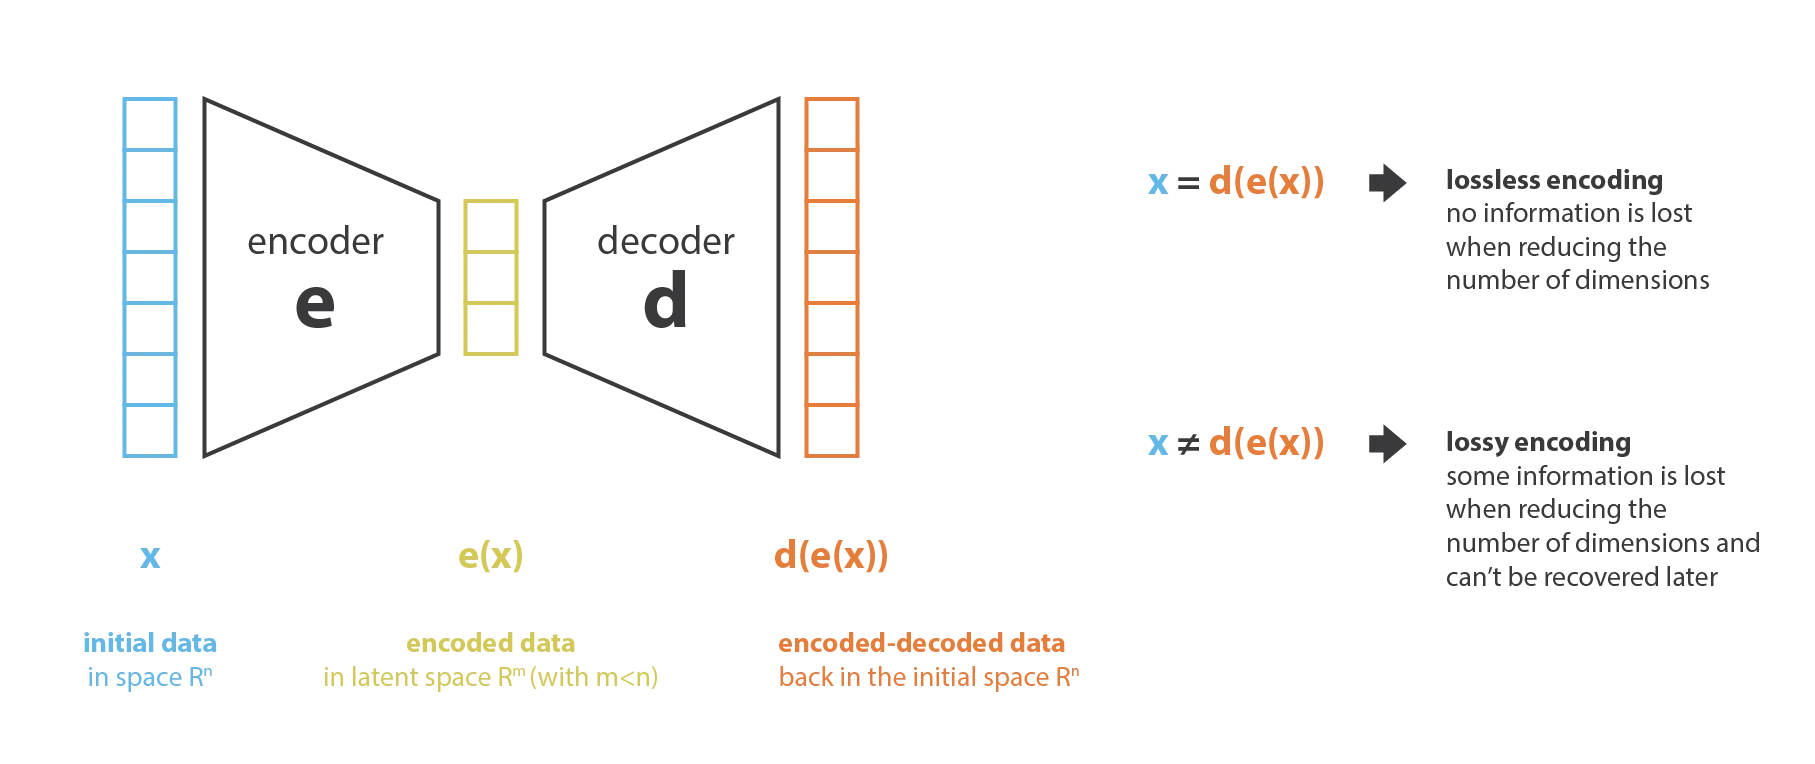

图：用编码器和解码器构建的降维过程。【蓝色的高维原始数据被编码器压缩到浅黄色的低维隐空间中,再由解码器解压缩。如果解码后的数据和原始数据相同（右上）则称为无损降维,否则为有损降维。】

In [11]:
# python环境
# - python 3.10
# - torch 1.13.1

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary
import numpy as np

#单个cell输出多个变量
# https://blog.csdn.net/weixin_43360896/article/details/114653915
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"


batch_size_train = 32 # We use a small batch size here for training
batch_size_test = 32 #
latent_dim = 2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", device)
# define how image transformed
image_transform = torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor()
                             ])
#image datasets
train_dataset = torchvision.datasets.MNIST('dataset/', train=True, download=True,transform=image_transform)
test_dataset = torchvision.datasets.MNIST('dataset/', train=False, download=True,transform=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size_train,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size_test, shuffle=True)

In [12]:
import matplotlib.pyplot as plt
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [13]:
example_data.shape

torch.Size([32, 1, 28, 28])

In [14]:
example_targets.shape

torch.Size([32])

可视化MNIST数据

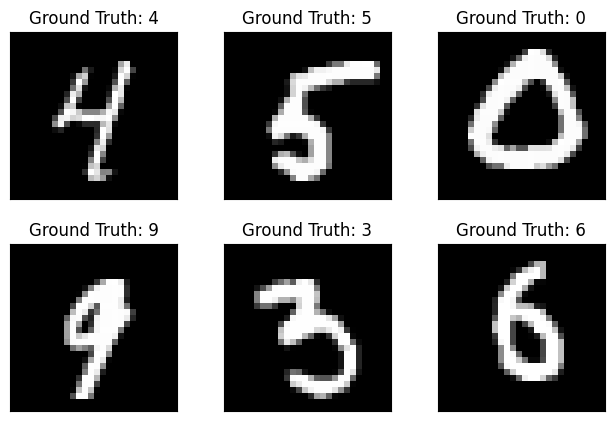

In [15]:
# https://nextjournal.com/gkoehler/pytorch-mnist
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])

## 构建VAE网络

一个基础编码器的结构图

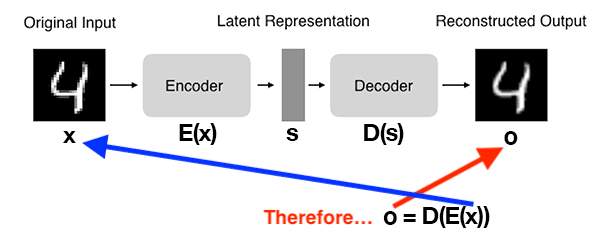

Figure : Architecture of Autoencoder (inspired by [Hubens, “Deep Inside: Autoencoders,” Towards Data Science, 2018](https://towardsdatascience.com/deep-inside-autoencoders-7e41f319999f)).


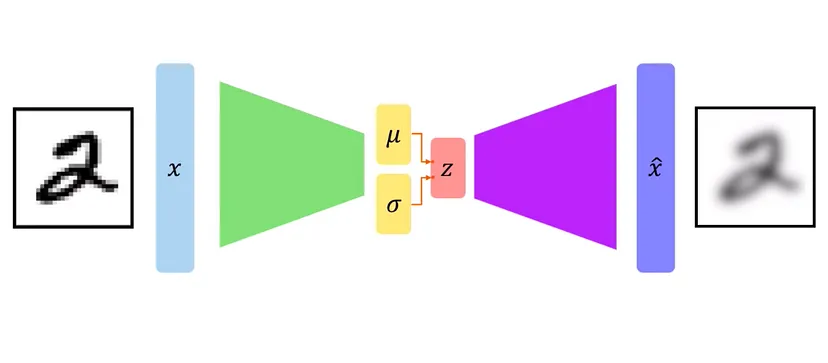

Figure : A Variational Autoencoder ([Source](https://www.youtube.com/watch?v=rZufA635dq4&ab_channel=AlexanderAmini))

卷积编码器,先把特征做压缩。

In [16]:
class Encoder(nn.Module):
    def __init__(self) -> None:
        super( ).__init__()
        self.conv1 = nn.Conv2d(1,32, kernel_size=(3,3), stride=(1,1), padding=(1,1))   
        self.conv2 = nn.Conv2d(32,64, kernel_size=3, stride=2, padding=1)   
        self.conv3 = nn.Conv2d(64,64, kernel_size=3, stride=1, padding=1)   
        self.conv4 = nn.Conv2d(64,64, kernel_size=3, stride=1, padding=1) 
        self.fc_1 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*14*14, 32),
            nn.ReLU()
        )
        
        
    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.fc_1(x)
        
        return x


在隐空间中,我们构建两神经网络$\mu=f_1(X_k), log\sigma^2_k=f_2(X_k)$,k是隐空间的维度。

我们直接拟合$log\sigma^2_k$, 而不是$\sigma^2_k$,因为$log\sigma^2_k$是非负的,不需要再加激活函数,所以在计算KL散度的loss时需要注意这个参数的定义。

代码中的mu就是$\mu=f_1(X_k)$,log_sigma2就是$log\sigma^2_k=f_2(X_k)$。

In [17]:
class LatentSpace(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.z_mu = nn.Linear(32, latent_dim)
        self.z_sigma = nn.Linear(32, latent_dim) 
        
    def forward(self, x):
        mu = self.z_mu(x)
        log_sigma2  = self.z_sigma(x)
        eps = torch.randn_like(mu)
        
        return mu, log_sigma2, mu+log_sigma2.exp().pow(0.5)* eps  # mu+sigma*eps

In [18]:
# 重参数算子调试
sigma= torch.tensor(5)
torch.log(sigma.pow(2)).exp().pow(0.5)

tensor(5.)

In [19]:
class Decoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.fc_1 = nn.Sequential(
            nn.Linear(2, 64*14*14),
            nn.ReLU()
        )
        self.conv1 = nn.ConvTranspose2d(64, 32, kernel_size=3, padding=1, stride=1)
        self.conv2 = nn.ConvTranspose2d(32, 1, kernel_size=4, padding=1, stride=2)
        # self.act = nn.Sigmoid()
    def forward(self, x):
        batch_size, n_channels = x.shape
        x = self.fc_1(x)
        x = x.view(batch_size, 64, 14, 14)
        # x = x.reshape(batch_size, 64, 14, 14)
        x = self.conv1(x)
        x = self.conv2(x)
        x = F.sigmoid(x)
        return x 
        
        
class VAE(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        self.encoder = Encoder()
        self.latent_space = LatentSpace()
        self.decoder = Decoder()
        
    def forward(self, x):
        x = self.encoder(x)
        mu, log_sigma2, x = self.latent_space(x)
        x = self.decoder(x)
        return  mu, log_sigma2, x

In [20]:
def summary_vae():
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = VAE().to(device) #using cpu here
    print(summary(model, input_size=(1, 1, 28, 28)))

summary_vae()

Layer (type:depth-idx)                   Output Shape              Param #
VAE                                      [1, 2]                    --
├─Encoder: 1-1                           [1, 32]                   --
│    └─Conv2d: 2-1                       [1, 32, 28, 28]           320
│    └─Conv2d: 2-2                       [1, 64, 14, 14]           18,496
│    └─Conv2d: 2-3                       [1, 64, 14, 14]           36,928
│    └─Conv2d: 2-4                       [1, 64, 14, 14]           36,928
│    └─Sequential: 2-5                   [1, 32]                   --
│    │    └─Flatten: 3-1                 [1, 12544]                --
│    │    └─Linear: 3-2                  [1, 32]                   401,440
│    │    └─ReLU: 3-3                    [1, 32]                   --
├─LatentSpace: 1-2                       [1, 2]                    --
│    └─Linear: 2-6                       [1, 2]                    66
│    └─Linear: 2-7                       [1, 2]                    

/opt/anaconda3/envs/sd-webui/lib/python3.10/site-packages/torch/nn/functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


## 损失函数
损失函数由两部分构成：
 - 输入的x和输出的d(x),称之为重构误差
 - 隐空间的分布和标准高斯分布之间的Kulback-Leibler散度
  
需要注意的时,2个loss是可以调整权重,进而影响学习的分布情况。具体？

KL散度的公式推导：

![Alt text](images/KL散度公式推导.png)

([图片源](https://kexue.fm/archives/5253))

In [21]:
def loss_function(x, x_hat, mu, log_sigma2):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_sigma2 - mu.pow(2) - log_sigma2.exp()) # log_sigma2.exp()= sigma2

    return reproduction_loss + KLD


In [22]:
# log_sigma2.exp()= sigma2
sigma2 = torch.tensor(2)
torch.log(sigma2).exp()

tensor(2.)

In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE().to(device) #using cpu here
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

def train(model, optimizer, epochs, device):
    model.train()
    for epoch in range(epochs):
        overall_loss = 0
        for batch_idx, (x, _) in enumerate(train_loader):
            x = x.to(device)

            optimizer.zero_grad()

            mu, log_sigma2, x_hat  = model(x)
            loss = loss_function(x, x_hat, mu, log_sigma2)
            
            overall_loss += loss.item()
            
            loss.backward()
            optimizer.step()
            
        print("\tEpoch", epoch + 1, "\tAverage Loss: ", overall_loss/(batch_idx*batch_size_train))
    return overall_loss

train(model, optimizer, epochs=50, device=device)

	Epoch 1 	Average Loss:  176.33800967449568
	Epoch 2 	Average Loss:  159.51862277394298
	Epoch 3 	Average Loss:  155.6313719042083
	Epoch 4 	Average Loss:  153.53129803994423
	Epoch 5 	Average Loss:  152.04030738594437
	Epoch 6 	Average Loss:  151.2290102532223
	Epoch 7 	Average Loss:  150.43173779189397
	Epoch 8 	Average Loss:  149.7671274492555
	Epoch 9 	Average Loss:  149.15198064130297
	Epoch 10 	Average Loss:  148.60330642732765
	Epoch 11 	Average Loss:  148.2313316573201
	Epoch 12 	Average Loss:  147.76439930560622
	Epoch 13 	Average Loss:  147.494933247439
	Epoch 14 	Average Loss:  147.13815985468943
	Epoch 15 	Average Loss:  146.80863054534032
	Epoch 16 	Average Loss:  146.59100316962667
	Epoch 17 	Average Loss:  146.35899947012757
	Epoch 18 	Average Loss:  146.0855983827768
	Epoch 19 	Average Loss:  145.95253689744555
	Epoch 20 	Average Loss:  145.68053994031192
	Epoch 21 	Average Loss:  145.6181846138253
	Epoch 22 	Average Loss:  145.39344686225232
	Epoch 23 	Average Loss:  1

8559458.6484375

训练完成后,可以从潜在空间中做采样,然后经过decoder,得到采用结果,看一下我们从潜在空间中的采用结果,以观察我们的训练结果。

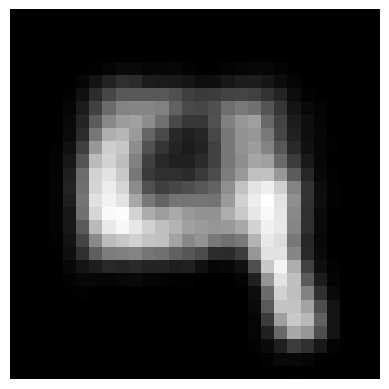

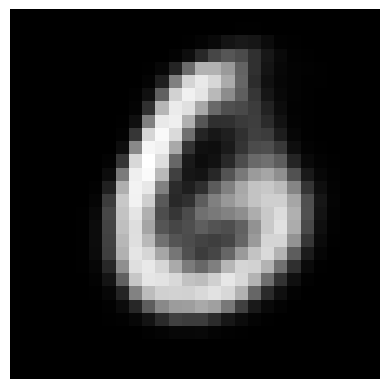

(None, None)

In [24]:
def generate_digit(mean, var):
    z_sample = torch.tensor([[mean, var]], dtype=torch.float).to(device)
    x_decoded = model.decoder(z_sample)
    digit = x_decoded.detach().cpu().reshape(28, 28) # reshape vector to 2d array
    plt.imshow(digit, cmap='gray')
    plt.axis('off')
    plt.show()

generate_digit(0.0, 1.0), generate_digit(1.0, 0.0)

均值和方差的取值范围修改为[-1,1],展示一下潜在空间的内容

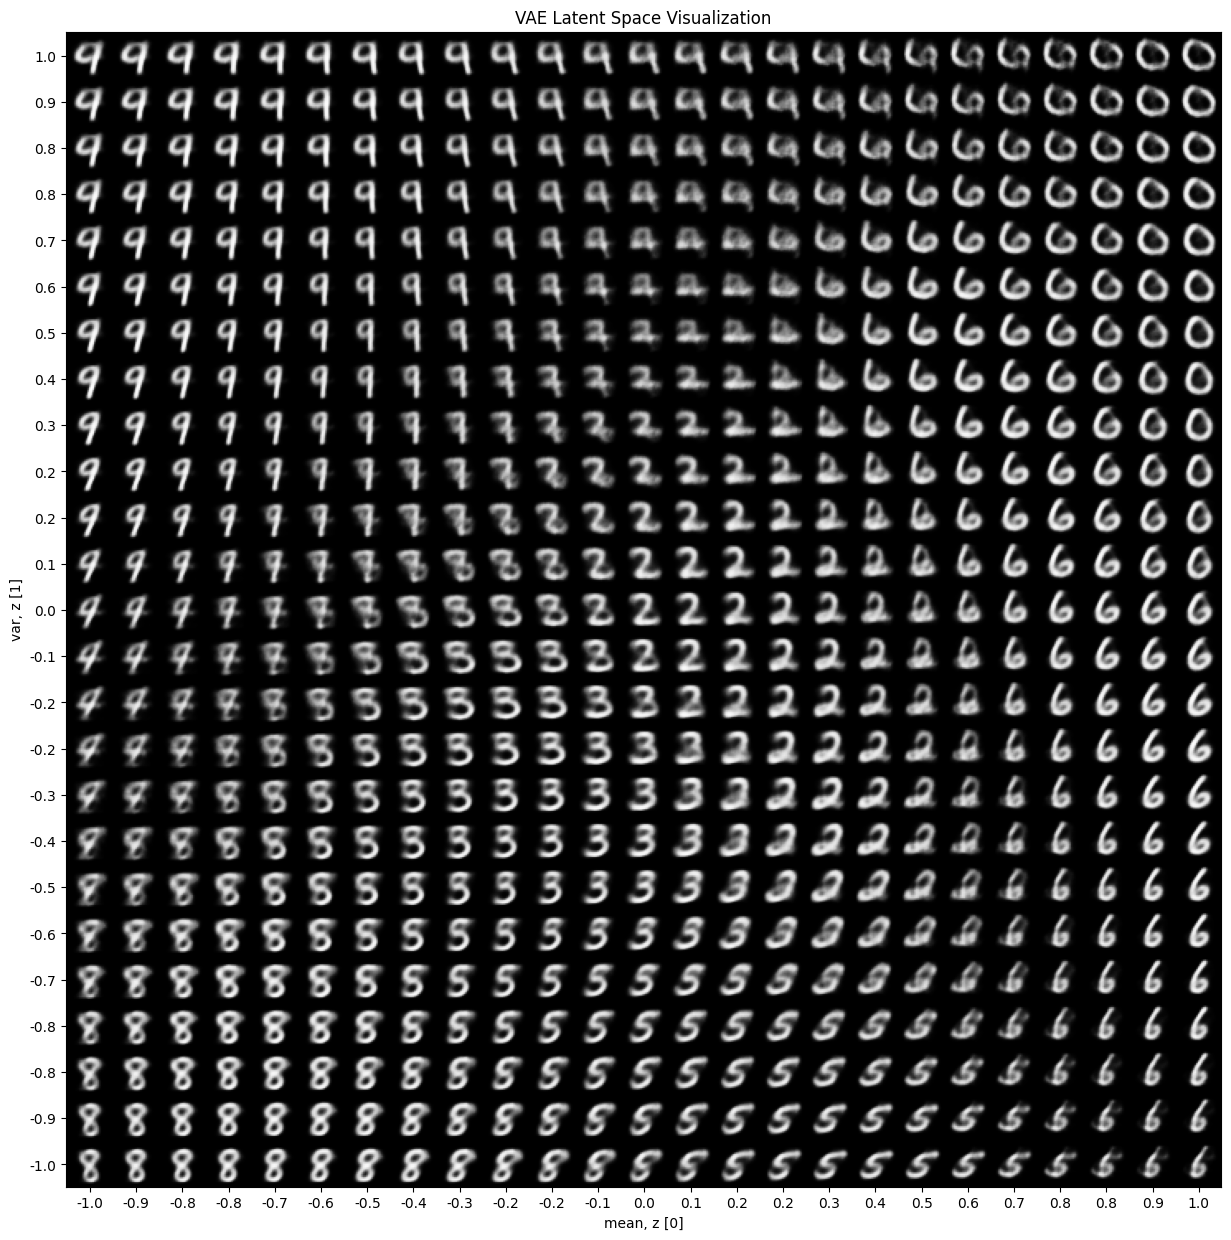

In [25]:
def plot_latent_space(model, scale=1.0, n=25, digit_size=28, figsize=15):
    # display a n*n 2D manifold of digits
    figure = np.zeros((digit_size * n, digit_size * n))

    # construct a grid 
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float).to(device)
            x_decoded = model.decoder(z_sample)
            digit = x_decoded[0].detach().cpu().reshape(digit_size, digit_size)
            figure[i * digit_size : (i + 1) * digit_size, j * digit_size : (j + 1) * digit_size,] = digit

    plt.figure(figsize=(figsize, figsize))
    plt.title('VAE Latent Space Visualization')
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("mean, z [0]")
    plt.ylabel("var, z [1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()


plot_latent_space(model)

均值和方差的取值范围修改为[-5,5],展示一下潜在空间的内容

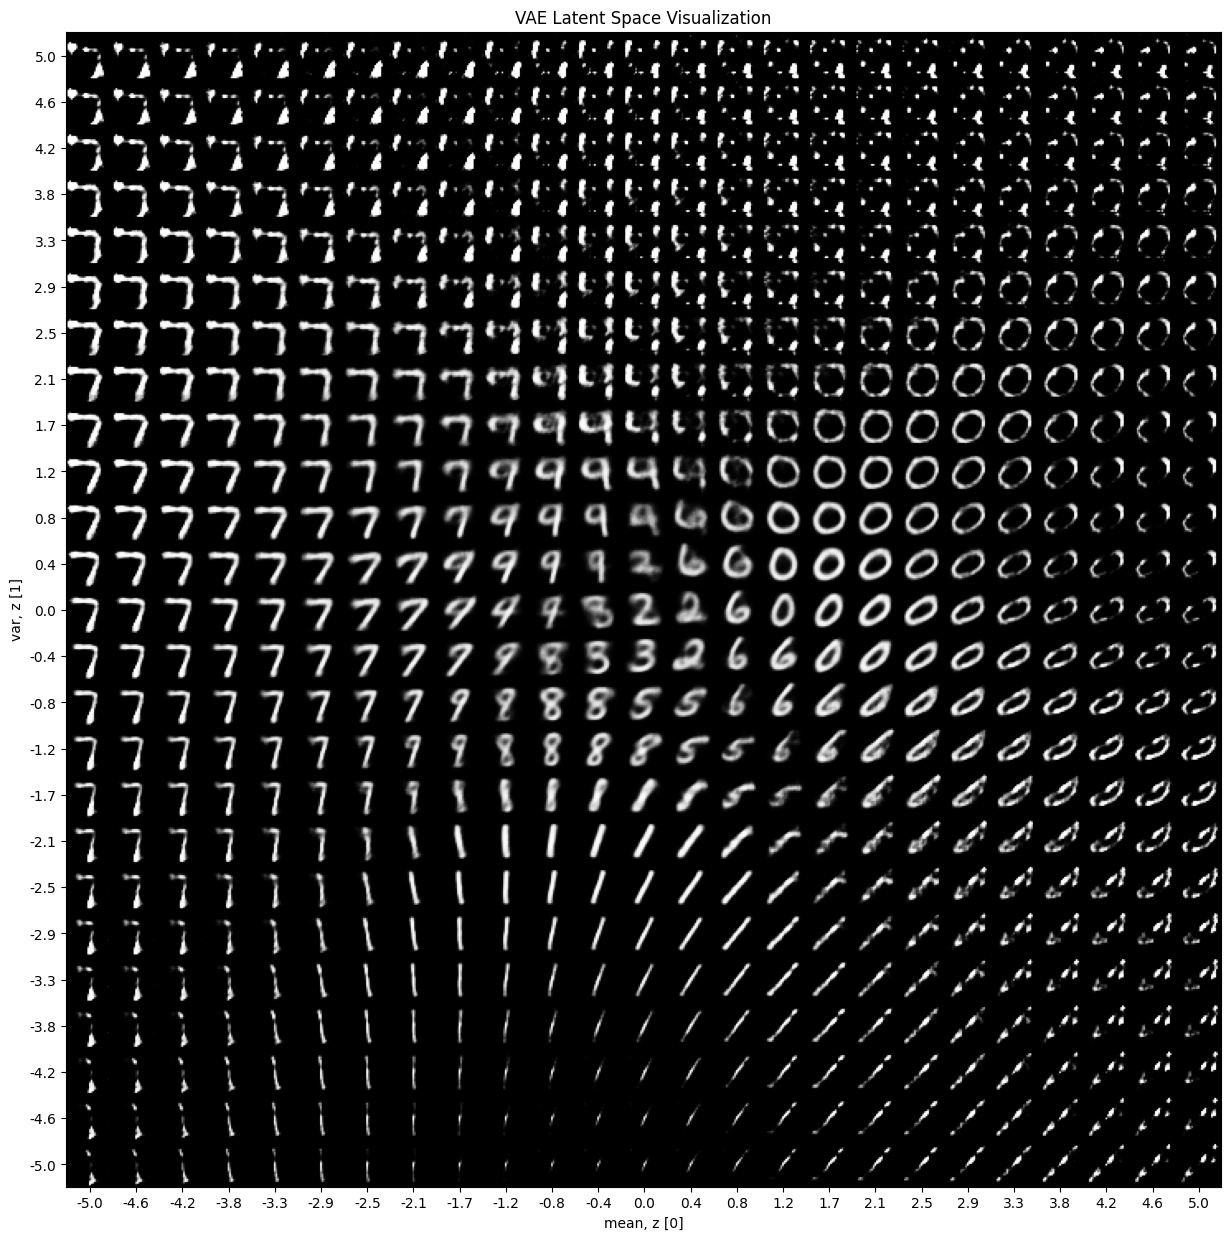

In [26]:
plot_latent_space(model,scale=5)

## 思考
- 潜在空间的维度（latent_dim=2）,可以修改为64,128等,在训练看看结果。

## 参考
- [Variational Autoencoder (VAE) — PyTorch Tutorial](https://medium.com/@rekalantar/variational-auto-encoder-vae-pytorch-tutorial-dce2d2fe0f5f)
  - 主要参考,图片展示+pytorch的部分代码

- [Introduction to Autoencoders](https://pyimagesearch.com/2023/07/10/introduction-to-autoencoders/)
  - 介绍了各种编码器

- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)
  - keras官方介绍的编码器

In [27]:
torch.exp(torch.tensor(1))


a = torch.tensor(2)
torch.log(a).exp()


# log_sigma2.exp()= sigma2
sigma2 = torch.log(torch.tensor(5**2))
sigma2

torch.exp(sigma2)

sigma2.exp()**0.5

sigma2.exp().pow(0.5)
sigma= torch.tensor(5)
torch.log(sigma.pow(2)).exp().pow(0.5)

tensor(5.)